# Praxisbeispiel - Reinforcement Learning Hands-on: Roboter im Raum

In diesem Notebook wird ein einfacher Q‑Learning-Algorithmus implementiert, mit dem ein Roboter (Agent) lernt, einen Ausgang in einem 2D-Gitter zu finden. Die Visualisierung ermöglicht es, den Entscheidungsprozess und die Pfadfindung Schritt für Schritt nachzuvollziehen.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Für Inline-Plots in Jupyter
%matplotlib inline

## Definition der Umgebung: GridWorld

Die Umgebung wird als 2D-Gitter modelliert, in dem der Roboter sich bewegen kann. Der Ausgang (Goal) wird als Zielzelle definiert.

In [3]:
class GridWorld:
    """
    Ein einfaches 2D-Grid, worin ein Agent von einer Start- zu einer Zielposition navigieren soll.
    
    Attribute:
        width (int): Breite des Gitters (Anzahl Spalten).
        height (int): Höhe des Gitters (Anzahl Zeilen).
        start (tuple): Startposition des Agenten als (x, y).
        goal (tuple): Zielposition (Ausgang) als (x, y).
        agent_pos (tuple): Aktuelle Position des Agenten als (x, y).
    """
    def __init__(self, width, height, start, goal):
        """
        Initialisiert die Gitterwelt mit den angegebenen Dimensionen und Positionen.

        Args:
            width (int): Breite des Gitters.
            height (int): Höhe des Gitters.
            start (tuple): Startposition des Agenten als (x, y).
            goal (tuple): Zielposition (Ausgang) als (x, y).
        """
        self.width = width
        self.height = height
        self.start = start
        self.goal = goal
        self.reset()

    def reset(self):
        """
        Setzt die Agentenposition auf die Startposition zurück (nach jeder Episode notwendig). 

        Returns:
            tuple: Die aktuelle (zurückgesetzte) Position des Agenten (x, y).
        """
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        """
        Führt einen Schritt in der Umgebung basierend auf der gegebenen Aktion aus.

        Aktionen werden wie folgt kodiert:
            0 = oben
            1 = rechts
            2 = unten
            3 = links

        Args:
            action (int): Index der gewählten Aktion (0 bis 3).

        Returns:
            tuple: Nächste Agentenposition (x, y) nach dem Schritt.
            float: Belohnung (Reward) für diesen Schritt.
            bool: True, falls das Ziel erreicht ist; False sonst.
        """
        x, y = self.agent_pos
        if action == 0:   # nach oben
            y = max(y - 1, 0)
        elif action == 1: # nach rechts
            x = min(x + 1, self.width - 1)
        elif action == 2: # nach unten
            y = min(y + 1, self.height - 1)
        elif action == 3: # nach links
            x = max(x - 1, 0)
        self.agent_pos = (x, y)
        reward = -1  # Schrittkosten
        done = False
        if self.agent_pos == self.goal:
            reward = 100
            done = True
        return self.agent_pos, reward, done

    def render(self):
        """
        Visualisiert die aktuelle Umgebung mit Hilfe von Matplotlib.

        - Zielzelle wird mit Grauton 0.5 dargestellt.
        - Agentenposition wird mit Weiß (1.0) dargestellt.
        """
        grid = np.zeros((self.height, self.width))
        # Zielzelle markieren
        grid[self.goal[1], self.goal[0]] = 0.5
        # Agentenposition markieren
        grid[self.agent_pos[1], self.agent_pos[0]] = 1
        plt.imshow(grid, cmap='gray_r')
        plt.xticks(range(self.width))
        plt.yticks(range(self.height))
        plt.show()
        plt.close()

## Q‑Learning Parameter und Initialisierung

Wir definieren die Lernparameter sowie die Q‑Tabelle. Die Aktionen werden wie folgt kodiert:

- 0: oben
- 1: rechts
- 2: unten
- 3: links

In [22]:
# Lernparameter
alpha = 0.1      # Lernrate
gamma = 0.9      # Diskontfaktor
epsilon = 0.2    # Explorationsrate 
episodes = 5     # Episoden

# Erstelle die Umgebung
env = GridWorld(4, 4, start=(0, 0), goal=(2, 3))

# Q‑Tabelle initialisieren: Dimensionen (Breite, Höhe, Anzahl Aktionen)
Q = np.zeros((env.width, env.height, 4))

def choose_action(state, Q, eps):
    """
    Wählt eine Aktion nach einer einfachen epsilon-greedy-Strategie (deterministische Variante).

    Diese Funktion prüft, ob eine Zufallszahl < epsilon ist:
      - Falls ja, wird eine zufällige Aktion (0-3) gewählt (exploration).
      - Falls nein, wird die Aktion mit dem höchsten Q-Wert gewählt (exploitation).

    Args:
        state (tuple): Aktueller Zustand des Agenten als (x, y).
        Q (numpy.ndarray): Q-Tabelle der Form (width, height, 4).
        epsilon (float): Wahrscheinlichkeit für zufällige Exploration (Wert zwischen 0 und 1).

    Returns:
        int: Index der gewählten Aktion (0 bis 3).
    """    
    if np.random.rand() < eps:
        return np.random.randint(4)
    else:
        x, y = state
        return np.argmax(Q[x, y, :])



## Training mit schrittweisr Grid-Visualisierung

In jeder Episode wird der Agent von der Startposition aus agieren, bis er den Ausgang erreicht. Nach jedem Schritt wird die aktuelle Position visualisiert.

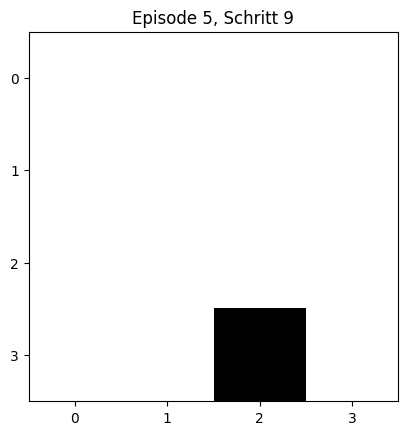

In [23]:
# Training mit schrittweiser Visualisierung
for ep in range(episodes):
    state = env.reset()
    done = False
    step_count = 0
    
    while not done:
        # Aktion wählen 
        action = choose_action(state, Q, epsilon)

        # Schritt in der Umgebung ausführen 
        next_state, reward, done = env.step(action)

        # Q-Update 
        x, y = state
        nx, ny = next_state
        Q[x, y, action] += alpha * (reward + gamma * np.max(Q[nx, ny, :]) - Q[x, y, action])

        # Zustand updaten
        state = next_state
        step_count += 1
        
        # Visualisierung aktualisieren
        clear_output(wait=True)
        grid = np.zeros((env.height, env.width))
        grid[env.goal[1], env.goal[0]] = 0.5  # Zielzelle
        grid[env.agent_pos[1], env.agent_pos[0]] = 1  # Agentenposition
        plt.imshow(grid, cmap='gray_r')
        plt.title(f'Episode {ep+1}, Schritt {step_count}')
        plt.xticks(range(env.width))
        plt.yticks(range(env.height))
        plt.show()
        time.sleep(0.1)

## Training, mit schrittweiser Grid-Visualisierung und simultanen Q-Table Wahrscheinlichkeiten für mögliche Aktionen

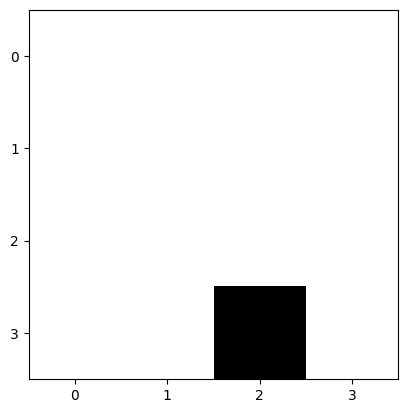

Episode 5 completed.


In [24]:
# Action names for visualization (4 actions: 0: Up, 1: Right, 2: Down, 3: Left)
action_names = ["Up", "Right", "Down", "Left"]

def get_action_probabilities(state, Q, eps):
    """
    Compute the epsilon-greedy probabilities for actions at the given state.
    
    Each action gets a base probability of eps/4, and the best action (argmax of Q-values)
    gets an additional probability mass of (1 - eps).

    Args:
        state (tuple): The current state as (x, y).
        Q (np.ndarray): Q-table with shape (width, height, 4).
        eps (float): Epsilon value (exploration rate).
        
    Returns:
        numpy.ndarray: A vector of probabilities for the 4 actions.
    """
    x, y = state
    q_vals = Q[x, y, :]
    best_action = np.argmax(q_vals)
    probs = np.ones(4) * (eps / 4.0)
    probs[best_action] += (1.0 - eps)
    return probs

# Training mit schrittweiser Visualisierung, inklusive Grid und der aktuellen Options-Wahrscheinlichkeiten und der gewählten Aktion 
for ep in range(episodes):
    state = env.reset()
    done = False
    step_count = 0

    while not done:
        clear_output(wait=True)
        # Erstelle eine neue Figur für diesen Schritt
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # Erstelle neues Grid-Display: 0 = leer, 0.5 = Ziel, 1 = Agent
        grid = np.zeros((env.height, env.width))
        grid[env.goal[1], env.goal[0]] = 0.5  # mark goal
        grid[env.agent_pos[1], env.agent_pos[0]] = 1  # Agents aktuelle Position
        
        # Plotte das Grid (Gitter)
        ax.imshow(grid, cmap='gray_r', vmin=0, vmax=1)
        ax.set_xticks(range(env.width))
        ax.set_yticks(range(env.height))
        ax.set_title(f"Episode {ep+1}, Step {step_count+1}")
        
        # Berechne epsilon-Greedy- Aktions-Wahrscheinlichkeiten für den aktuellen Zustand
        probs = get_action_probabilities(state, Q, epsilon)
        # Wähle eine Aktion anhand der bestehenden Epsilon-Greedy-Funktion
        action = choose_action(state, Q, epsilon)
        
        # Zeige die berechneten Wahrscheinlichkeiten und die gewählte aktion nebem dem Grid 
        text_str = (
            f"Action probabilities:\n"
            f"Up: {probs[0]:.2f}\n"
            f"Right: {probs[1]:.2f}\n"
            f"Down: {probs[2]:.2f}\n"
            f"Left: {probs[3]:.2f}\n\n"
            f"Chosen action: {action} ({action_names[action]})"
        )
        # Text rechts vom Raster platzieren, ggf. Koordination anpassen
        ax.text(env.width + 0.5, env.height/2, text_str, fontsize=10, va='center')
        
        plt.tight_layout()
        plt.show()
        
        # Führe die Aktion durch und aktualisiere den Q-Wert
        next_state, reward, done = env.step(action)
        nx, ny = next_state
        Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[nx, ny, :]) - Q[state[0], state[1], action])
        state = next_state
        step_count += 1
        
        time.sleep(1)  # Pause, damit der Schritt sichtbar ist
    
    # End-of-eEpisode Message
    clear_output(wait=True)
    env.render()
    print(f"Episode {ep+1} completed.")
    time.sleep(1.0)

## Trainiertes Modell: Darstellung des optimalen Pfads

Nach dem Training wird der Agent den erlernten (nahezu) optimalen Pfad zum Ausgang demonstrieren.

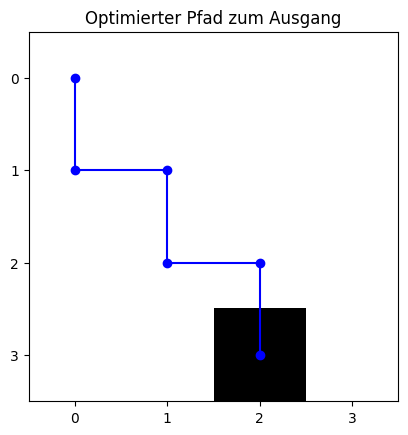

In [25]:
# Reset und initialisiere Pfadspeicher
state = env.reset()
done = False
path = [state]

while not done and len(path) < 100:
    x, y = state
    action = np.argmax(Q[x, y, :])
    state, _, done = env.step(action)
    path.append(state)

# Visualisierung des gefundenen Pfads
grid = np.zeros((env.height, env.width))
grid[env.goal[1], env.goal[0]] = 0.5  # Zielzelle
plt.imshow(grid, cmap='gray_r')
x_coords = [pos[0] for pos in path]
y_coords = [pos[1] for pos in path]
plt.plot(x_coords, y_coords, marker='o', color='blue')
plt.title('Optimierter Pfad zum Ausgang')
plt.xticks(range(env.width))
plt.yticks(range(env.height))
plt.show()